### Define Read and format datasheets methods

In [ ]:
import pandas as pd

# Note the following features of the Fidelity CSV account monthly statement:

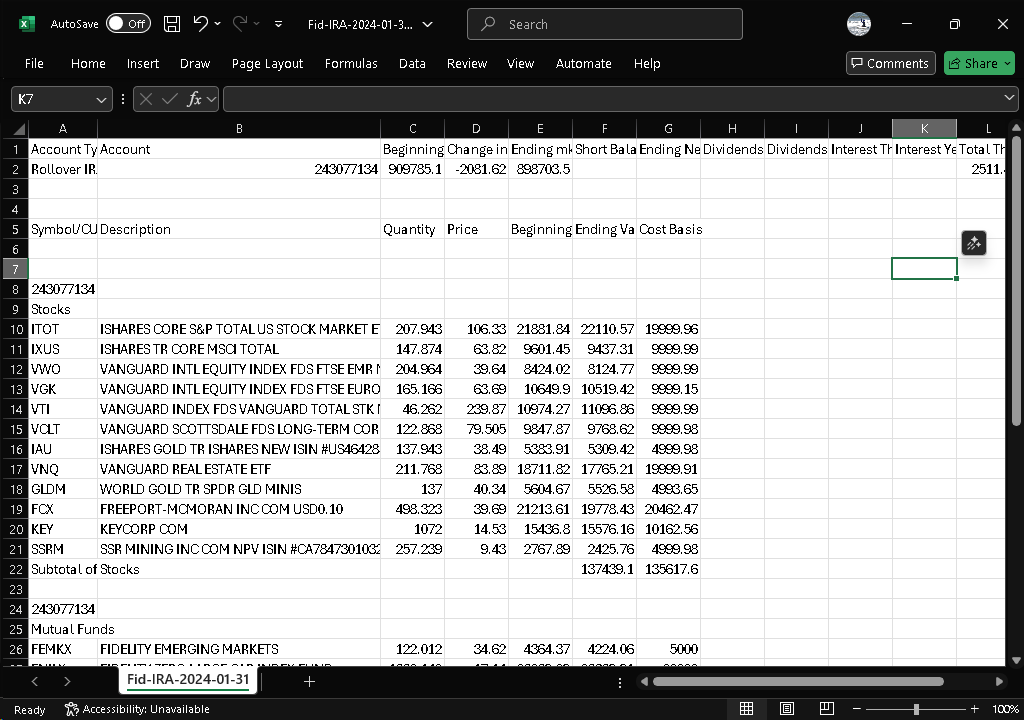

## column names appearing under the header: 
Symbol/CUSIP,Description,Quantity,Price,Beginning Value,Ending Value,Cost Basis

### 🧾 Sample Fidelity CSV (Excerpt)

```csv
Account Type,Account,Beginning mkt Value,Change in Investment,Ending mkt Value,Short Balance,Ending Net Value,Dividends This Period,Dividends Year to Date,Interest This Year,Interest Year to Date,Total This Period,Total Year to Date
Rollover IRA,243077134,909785.11,-2081.62,898703.49,,,,,,,2511.88,2511.88
 

Symbol/CUSIP,Description,Quantity,Price,Beginning Value,Ending Value,Cost Basis
 

243077134 
Stocks 
ITOT,ISHARES CORE S&P TOTAL US STOCK MARKET ETF ,207.94300,106.33000,21881.84,22110.57,19999.96
IXUS,ISHARES TR CORE MSCI TOTAL ,147.87400,63.82000,9601.45,9437.31,9999.99
VWO,VANGUARD INTL EQUITY INDEX FDS FTSE EMR MKT ETF ,204.96400,39.64000,8424.02,8124.77,9999.99
VGK,VANGUARD INTL EQUITY INDEX FDS FTSE EUROPE ETF ,165.16600,63.69000,10649.90,10519.42,9999.15
VTI,VANGUARD INDEX FDS VANGUARD TOTAL STK MKT ETF ,46.26200,239.87000,10974.27,11096.86,9999.99
VCLT,VANGUARD SCOTTSDALE FDS LONG-TERM CORP BOND IDX FUND ,122.86800,79.50500,9847.87,9768.62,9999.98
IAU,ISHARES GOLD TR ISHARES NEW ISIN #US4642852044 SEDOL #BKP74N6 ,137.94300,38.49000,5383.91,5309.42,4999.98
VNQ,VANGUARD REAL ESTATE ETF ,211.76800,83.89000,18711.82,17765.21,19999.91
GLDM,WORLD GOLD TR SPDR GLD MINIS ,137.00000,40.34000,5604.67,5526.58,4993.65
FCX,FREEPORT-MCMORAN INC COM USD0.10 ,498.32300,39.69000,21213.61,19778.43,20462.47
KEY,KEYCORP COM ,1072.00000,14.53000,15436.80,15576.16,10162.56
SSRM,SSR MINING INC COM NPV ISIN #CA7847301032 SEDOL #BF7MPL9 ,257.23900,9.43000,2767.89,2425.76,4999.98
Subtotal of Stocks,,,,,137439.11,135617.61, 

243077134 
Mutual Funds 
FEMKX,FIDELITY EMERGING MARKETS ,122.01200,34.62000,4364.37,4224.06,5000.00
FNILX,FIDELITY ZERO LARGE CAP INDEX FUND ,1382.14200,17.14000,23289.09,23689.91,20000.00
FSKAX,FIDELITY TOTAL MARKET INDEX FUND ,42.09900,133.21000,5546.54,5608.01,5000.00
FRESX,FIDELITY REAL ESTATE INVESTMENT ,508.54200,36.66000,19578.87,18643.15,20000.00
FSMDX,FIDELITY MID CAP INDEX FUND ,551.04400,29.53000,16503.77,16272.33,15000.00
FZILX,FIDELITY ZERO INTERNATIONAL INDEX ,904.89700,10.90000,10017.21,9863.38,10000.00
FIMVX,FIDELITY MID CAP VALUE INDEX FD ,838.00400,24.69000,21067.42,20690.32,20000.00
FAGIX,FIDELITY CAPITAL & INCOME ,1132.95400,9.66000,10887.38,10944.34,10000.00
FXNAX,FIDELITY U.S. BOND INDEX FUND ,4931.88500,10.39000,51301.48,51242.29,55536.07
Subtotal of Mutual Funds,,,,,161177.79,160536.07,,, 

243077134 
Core Account 
SPAXX,FIDELITY GOVERNMENT MONEY MARKET ,550088.09000,1.00000,556759.43,550088.09,not applicable
Subtotal of Core Account,,,,,550088.09,, 

243077134 
Other 
46593LJ83,JPMORGAN CHASE BK N A CD 4.75000% 02/02/2024 FIXED COUPON ,50000.00000,0.99997,49971.50,49998.50,50000.00
Subtotal of Other,,,,,49998.50,50000.00,,,
```

In [ ]:
# Define constants matching Fidelity download statement
FID_STOCKS_SECTION_HEADER = "Stocks"
FID_MUTUAL_FUNDS_SECTION_HEADER = "Mutual Funds"
FID_SYMBOL_CUSIP_COLUMN = "Symbol/CUSIP"
FID_BEGINNING_VALUE_COLUMN = "Beginning Value"
FID_ENDING_VALUE_COLUMN = "Ending Value"
FID_COST_BASIS_COLUMN = "Cost Basis"

ABREVIATED_BEGINNING_VALUE_COLUMN = "Begin Val"
ABREVIATED_ENDING_VALUE_COLUMN = "End Val"
ABREVIATED_VALUE_ID = "Val ("

# Define a function to extract and format monthly stocks or mutual funds info from a file
from typing import List

def format_monthly_section_info(
    file_path: str,
    month_tag: str,
    section_header: str,
    preferred_order: List[str]
) -> pd.DataFrame:
    """
    Extracts and formats monthly stocks or mutual funds info from a file.

    Parameters:
        file_path (str): Path to the CSV or text file.
        month_tag (str): Tag or identifier for the target month.
        section_header (str): String pattern identifying the beginning of the desired data section.
        preferred_order (List[str]): List of tickers or fund names in preferred display order.

    Returns:
        pandas.DataFrame: Cleaned DataFrame containing selected financial columns in the preferred order.

    Extracts and formats data from a section (Stock or Mutual Funds) of a Fidelity monthly statement 
    reads a CSV file, extracts selected colums, appends yr/month tag to value columns, 
    returns a cleaned and sorted pandas DataFrame. 

    The function locates the start of the section using the specified header,
    trims the section based on blank rows or sentinel values (e.g., "Core Account", "Subtotal"),
    standardizes column names, filters key financial columns, and sorts based on a preferred symbol order.

    :Example:

    >>> df_cleaned = format_monthly_section_info(
    ...     "monthly_report.csv",
    ...     "Equities",
    ...     ["AAPL", "GOOG", "MSFT"]
    ... )
    """
    df = pd.read_csv(file_path)

    # Locate section start
    start_idx = df[df.iloc[:, 0].astype(str).str.contains(section_header, na=False)].index[0] + 1
    df_section = df.iloc[start_idx:].copy()

    # Stop at blank or next section
    stop_idx = df_section[
        df_section.iloc[:, 1].isna() |
        df_section.iloc[:, 1].astype(str).str.strip().eq("") |
        df_section.iloc[:, 1].astype(str).str.contains("Core Account|Subtotal", na=False)
    ].index
    if not stop_idx.empty:
        df_section = df_section.loc[:stop_idx[0] - 1]

    df_section = df_section.reset_index(drop=True)

    # Rename and clean columns
    df_section.columns = df.columns
    df_section.rename(columns={df.columns[0]: "Symbol/CUSIP", df.columns[1]: "Description"}, inplace=True)

    desired_columns = [
        "Symbol/CUSIP", "Description", "Quantity", "Price",
        FID_BEGINNING_VALUE_COLUMN, FID_ENDING_VALUE_COLUMN, FID_COST_BASIS_COLUMN
    ]
    df_section.columns = desired_columns + [f"drop_{i}" for i in range(len(df_section.columns) - len(desired_columns))]
    df_section = df_section[desired_columns]

    # Reorder columns
    column_order = [
        "Symbol/CUSIP", "Description", "Quantity", "Price",
        FID_COST_BASIS_COLUMN, FID_BEGINNING_VALUE_COLUMN, FID_ENDING_VALUE_COLUMN
    ]
    df_section = df_section[column_order]

    # Convert numeric columns to float where applicable
    numeric_columns = ["Quantity", "Price", FID_COST_BASIS_COLUMN, FID_BEGINNING_VALUE_COLUMN, FID_ENDING_VALUE_COLUMN]
    df_section[numeric_columns] = df_section[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # Apply preferred order
    df_section["Symbol/CUSIP"] = pd.Categorical(df_section["Symbol/CUSIP"], categories=preferred_order, ordered=True)
    df_section = df_section.sort_values("Symbol/CUSIP").reset_index(drop=True)

    # Format and rename columns to include month tag
    df_section.rename(columns={
        FID_BEGINNING_VALUE_COLUMN: f"{ABREVIATED_BEGINNING_VALUE_COLUMN} ({month_tag})",
        FID_ENDING_VALUE_COLUMN: f"{ABREVIATED_ENDING_VALUE_COLUMN} ({month_tag})"
    }, inplace=True)

    return df_section

In [ ]:
# Define a function to extract monthly beginning and ending values for a given month
def extract_monthly_beginning_and_ending_values(df_stocks, month_tag):
    """
    Extract and rename beginning and ending value columns with a month tag.
    """
    return df_stocks[["Symbol/CUSIP", f"Beginning Value", f"Ending Value"]].rename(
        columns={
            "Beginning Value": f"Beginning Value ({month_tag})",
            "Ending Value": f"Ending Value ({month_tag})"
        }
    )

In [ ]:
# Define a function to extract a specific column from a formatted monthly df
def extract_and_rename_column(df_monthly, column_name, new_column_name):
    """
    Extract one column (e.g., 'Ending Value') from a formatted monthly df,
    rename it and return a DataFrame with Symbol/CUSIP + that column.
    """
    return df_monthly[["Symbol/CUSIP", column_name]].rename(columns={column_name: new_column_name})

In [ ]:
# Define a function to extract a specific column from a formatted monthly df
def extract_column(df_monthly, column_name):
    """
    Extract one column (e.g., 'Ending Value') from a formatted monthly df,
    and return a DataFrame with Symbol/CUSIP + that column.
    """
    return df_monthly[["Symbol/CUSIP", column_name]]

In [ ]:
# Define a function to extract specified list of columns from a formatted monthly df
def extract_columns(df_monthly, column_names):
    """
    Extract specified columns from a formatted monthly DataFrame,
    always including 'Symbol/CUSIP'.
    """
    return df_monthly[["Symbol/CUSIP"] + column_names].copy()

In [ ]:
# Define a function to append monthly values to the master_df
def append_monthly_values_rigid(master_df, monthly_values_df):
    """
    Join the monthly values to the master_df using 'Symbol/CUSIP' as key,
    and append the new columns at the end.
    NOTE that this function does not add new rows and does not fill in missing values
    """
    merged = pd.merge(master_df, monthly_values_df, on="Symbol/CUSIP", how="left")
    
    # Move newly added columns to the end
    fixed_cols = [col for col in master_df.columns]
    new_cols = [col for col in merged.columns if col not in fixed_cols and col != "Symbol/CUSIP"]
    final_cols = fixed_cols + new_cols
    return merged[final_cols]

In [ ]:
def append_monthly_values(master_df, monthly_values_df):
    """
    Merge monthly values and metadata into the master DataFrame.
    Adds new holdings and fills in metadata fields for newly introduced rows only.
    """
    merged = pd.merge(master_df, monthly_values_df, on="Symbol/CUSIP", how="outer", suffixes=("", "_new"))

    # For any metadata fields present in the new data, fill them into master if master has nulls
    metadata_fields = ["Cost Basis", "Price", "Quantity", "Description"]
    for field in metadata_fields:
        if f"{field}_new" in merged.columns:
            merged[field] = merged[field].combine_first(merged[f"{field}_new"])
            merged.drop(columns=[f"{field}_new"], inplace=True)

    # Sort columns: keep existing order, add any new time-specific columns at the end
    fixed_cols = list(master_df.columns)
    new_cols = [col for col in merged.columns if col not in fixed_cols and col != "Symbol/CUSIP"]
    final_cols = ["Symbol/CUSIP"] + [col for col in fixed_cols if col != "Symbol/CUSIP"] + new_cols

    return merged[final_cols]

### Execute read and formatting methods

In [ ]:
# Define the list of monthly files to process and their corresponding tags
monthly_reports_2025 = {
    "Jan": "Fid-IRA-2025-01-31.csv",
    "Feb": "Fid-IRA-2025-02-28.csv",
    "Mar": "Fid-IRA-2025-03-31.csv",
    "Apr": "Fid-IRA-2025-04-30.csv",
    "May": "Fid-IRA-2025-05-31.csv"
}

In [ ]:
monthly_reports_2024 = {
    "Jan": "Fid-IRA-2024-01-31.csv",
    "Feb": "Fid-IRA-2024-02-29.csv",
    "Mar": "Fid-IRA-2025-03-31.csv",
    "Apr": "Fid-IRA-2024-04-30.csv",
    "May": "Fid-IRA-2024-05-31.csv",
    "Jun": "Fid-IRA-2024-06-30.csv",
    "Jul": "Fid-IRA-2024-07-31.csv",
    "Aug": "Fid-IRA-2024-08-31.csv",
    "Sep": "Fid-IRA-2024-09-30.csv",
    "Oct": "Fid-IRA-2024-10-31.csv",
    "Nov": "Fid-IRA-2024-11-30.csv",
    "Dec": "Fid-IRA-2024-12-31.csv"
}

In [ ]:
monthly_reports = {
    "24Jan": "Fid-IRA-2024-01-31.csv",
    "24Feb": "Fid-IRA-2024-02-29.csv",
    "24Mar": "Fid-IRA-2025-03-31.csv",
    "24Apr": "Fid-IRA-2024-04-30.csv",
    "24May": "Fid-IRA-2024-05-31.csv",
    "24Jun": "Fid-IRA-2024-06-30.csv",
    "24Jul": "Fid-IRA-2024-07-31.csv",
    "24Aug": "Fid-IRA-2024-08-31.csv",
    "24Sep": "Fid-IRA-2024-09-30.csv",
    "24Oct": "Fid-IRA-2024-10-31.csv",
    "24Nov": "Fid-IRA-2024-11-30.csv",
    "24Dec": "Fid-IRA-2024-12-31.csv",
    "25Jan": "Fid-IRA-2025-01-31.csv",
    "25Feb": "Fid-IRA-2025-02-28.csv",
    "25Mar": "Fid-IRA-2025-03-31.csv",
    "25Apr": "Fid-IRA-2025-04-30.csv",
    "25May": "Fid-IRA-2025-05-31.csv"
}

In [ ]:
preferred_stocks_order = [
    "SNOW",   # SNOWFLAKE INC CL A
    "KEY",   # KEYCORP COM
    "FCX",   # FREEPORT-MCMORAN INC COM USD0.10
    "SSRM",  # SSR MINING INC COM NPV ISIN #CA7847301032 SEDOL #BF7MPL9
    "ITOT",  # ISHARES CORE S&P TOTAL US STOCK MARKET ETF
    "IXUS",  # ISHARES TR CORE MSCI TOTAL
    "VTI",   # VANGUARD INDEX FDS VANGUARD TOTAL STK MKT ETF
    "VWO",   # VANGUARD INTL EQUITY INDEX FDS FTSE EMR MKT ETF
    "VGK",   # VANGUARD INTL EQUITY INDEX FDS FTSE EUROPE ETF
    "VNQ",   # VANGUARD REAL ESTATE ETF
    "VCLT",  # VANGUARD SCOTTSDALE FUNDS LONG-TERM CORP BOND IDX FUND
    "IAU",   # ISHARES GOLD TR ISHARES NEW ISIN #US4642852044 SEDOL #BKP74N6
    "GLDM"   # WORLD GOLD TR SPDR GLD MINIS
]

preferred_fund_order = [
    "FSKAX",  # FIDELITY TOTAL MARKET INDEX FUND
    "FNILX",  # FIDELITY ZERO LARGE CAP INDEX FUND
    "FSMDX",  # FIDELITY MID CAP INDEX FUND
    "FIMVX",  # FIDELITY MID CAP VALUE INDEX FD
    "FZILX",  # FIDELITY ZERO INTERNATIONAL INDEX
    "FEMKX",  # FIDELITY EMERGING MARKETS
    "FRESX",  # FIDELITY REAL ESTATE INVESTMENT
    "FAGIX",  # FIDELITY CAPITAL & INCOME
    "FXNAX"   # FIDELITY U.S. BOND INDEX FUND
]

In [ ]:
# Custom order
asset_category_order = [
    # Individual Stocks
    "SNOW", "KEY", "FCX", "SSRM",
    
    # US Equity
    "VTI", "FSMDX", "FNILX", "ITOT", "FIMVX",
    
    # International Equity
    "VGK", "IXUS", "FZILX", "VWO", "FEMKX",
    
    # Real Estate
    "VNQ", "FSKAX", "FRESX",
    
    # Bonds
    "VCLT", "FAGIX", "FXNAX",
    
    # Gold
    "GLDM", "IAU"
]

def reorder_assets_reverse(df, custom_order):
    reordered = df.set_index("Symbol/CUSIP").loc[custom_order[::-1]].reset_index()
    return reordered

def reorder_assets(df, custom_order):
    reordered = df.set_index("Symbol/CUSIP").loc[custom_order].reset_index()
    return reordered

In [ ]:
# Test integration of some functions without looping though months
def test_method_integration():
    # Step 1: Format full stock data for the current month
    df_jul = format_monthly_stock_info("Fid-IRA-2024-12-31.csv", "Dec")

    # Show full column list and the top few rows
    print("Columns:", df.columns.tolist())
    df_raw.head(15)
    
    # Step 2: Set up your master DataFrame based on July’s full data
    master_df = df_jul.copy()

    # Step 3: Extract just the monthly value columns for August
    df_jan = format_monthly_stock_info("Fid-IRA-2025-01-31.csv", "Jan")
    jan_beginining_ending_values_df = extract_monthly_beginning_and_ending_values(df_jan, "Jan")
    jan_ending_value = extract_monthly_column_values(df_jan, "Endign Value", "Jan")

    # Step 4: Append to master all
    master_all_df = append_monthly_values(master_df, jan_beginining_ending_values_df)
    display(master_all_df)
    # Step 4: Append to master ending
    master_ending_df = append_monthly_values(master_df, jan_beginining_ending_values_df)
    display(master_ending_df)
        
    # Step 2: Initialize the master dataframe
    master_df = None

    # Step 4: Loop through months and merge into master
    for month, filepath in monthly_reports.items():
        month_df = format_monthly_stock_info(filepath, month)

        if master_df is None:
            master_df = month_df
        else:
            price_colums_df = extract_monthly_column_values(month_df, "Ending Value", month)
            master_df = append_monthly_values(master_df, price_colums_df)
            
    # Optional: Fill missing values if any
    # master_df = master_df.fillna(0)

    # Preview final merged result
    pd.set_option('display.float_format', '${:,.2f}'.format)
    display(master_df)

In [ ]:
#  Read and Format ordered mutual funds price data for all the monthly_reports 

# Step 2: Initialize the master dataframe
mutual_funds_df = None

# Step 4: Loop through months and merge into master
for month, filepath in monthly_reports.items():
    month_df = format_monthly_section_info(filepath, month, FID_MUTUAL_FUNDS_SECTION_HEADER, preferred_fund_order)

    if mutual_funds_df is None:
        mutual_funds_df = month_df
    else:
        columns_to_extract = [f"{ABREVIATED_ENDING_VALUE_COLUMN} ({month})", "Cost Basis", "Price", "Quantity", "Description"]
        price_colums_df = extract_columns(month_df, columns_to_extract)
        mutual_funds_df = append_monthly_values(mutual_funds_df, price_colums_df)


# Optional: Fill missing values if any
# master_df = master_df.fillna(0)

# Preview final merged result
pd.set_option('display.float_format', '${:,.2f}'.format)
display(mutual_funds_df)

In [ ]:
# Read and Format ordered stocks price data for all the monthly_reports

# Step 2: Initialize the master dataframe
stocks_df = None

# Step 4: Loop through months and merge into master
for month, filepath in monthly_reports.items():
    month_df = format_monthly_section_info(filepath, month, FID_STOCKS_SECTION_HEADER, preferred_stocks_order)

    if stocks_df is None:
        stocks_df = month_df
    else:
        columns_to_extract = [f"{ABREVIATED_ENDING_VALUE_COLUMN} ({month})", "Cost Basis", "Price", "Quantity", "Description"]
        price_colums_df = extract_columns(month_df, columns_to_extract)
        stocks_df = append_monthly_values(stocks_df, price_colums_df)


# Optional: Fill missing values if any
# master_df = master_df.fillna(0)

# Preview final merged result
pd.set_option('display.float_format', '${:,.2f}'.format)
display(stocks_df)

In [ ]:
# Add Stock/Mutual Fund column as types to each dataframe
stocks_df["Type"] = "Stock"
mutual_funds_df["Type"] = "Fund"

# Combine dataframes into one 
df_combined = pd.concat([stocks_df, mutual_funds_df], ignore_index=True)

# Move 'Type' to the first column
cols = df_combined.columns.tolist()
cols.insert(0, cols.pop(cols.index("Type")))
df_combined = df_combined[cols]

display(df_combined)

### Define Plotting Routines

Matplotlib has a whole palette of colormaps you can experiment with, each with its own vibe and clarity. Here are some great options to try when plotting many distinct lines:

🎨 Qualitative (great for categories like stocks/funds)
- tab20, tab20b, tab20c — 20-color palettes with good separation
- Set1, Set2, Set3 — vibrant and distinct, especially Set3 for larger sets
- Accent, Paired, Dark2 — more muted but still distinguishable

🌈 Continuous (for gradients or smooth transitions)
- viridis, plasma, inferno, magma, cividis — perceptually uniform and colorblind-friendly
- nipy_spectral — rainbow-like, good for lots of lines with contrast

🧪 How to preview them
You can list all available colormaps in your environment with:

🧠 Tips:
- You can pass any valid colormap name like "Set3", "nipy_spectral", "Dark2", or "viridis".
- Want smooth transitions? Try cividis, plasma, or turbo.
- For strong line separation, stick with qualitative maps like Set1, tab20, or Paired


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [ ]:
# check available colormaps
print(plt.colormaps())

In [ ]:
def plot_colormaps():
    # play with colormaps
    gradient = np.linspace(0, 1, 256).reshape(1, -1)

    for cmap_name in plt.colormaps():
        plt.figure(figsize=(6, 0.4))
        plt.imshow(gradient, aspect='auto', cmap=plt.get_cmap(cmap_name))
        plt.axis('off')
        plt.title(cmap_name, fontsize=8, loc='left')
        plt.show()

In [ ]:
def plot_relative_performance_using_colormap(df_combined, colormap_name="tab20"):
    """
    Plots the relative performance of holdings over time using a specified colormap.

    This function normalizes the value of each holding to its initial value (base = 100),
    and plots a line graph to show their comparative performance over time. The lines are
    color-coded using the specified colormap for better distinction.

    :param df_combined: A DataFrame containing time-series value columns and a "Symbol/CUSIP" column.
    :type df_combined: pandas.DataFrame
    :param colormap_name: Name of the matplotlib colormap to use for the lines (e.g., "tab20", "Set3").
    :type colormap_name: str

    :return: None (displays a line plot)
    :rtype: None

    :Example:

    >>> plot_relative_performance_using_colormap(df_combined, colormap_name="Set3")
    """

    # filter DataFrame to grab only the time-series of columns with monthly “Ending Value”. 
    # It's using a constant (ABREVIATED_VALUE_ID) to identify them.
    value_cols = [col for col in df_combined.columns if ABREVIATED_VALUE_ID in col]
    # set the holdings as the row index (by ticker or CUSIP), 
    # and leave just the columns of monthly ending values. 
    # Now each row is a holding, and each column is a point in time
    df_plot = df_combined.set_index("Symbol/CUSIP")[value_cols].copy()
    # do the normalization magic:
    # - Each holding is divided by its own first month value.
    # - Then multiplied by 100 to express performance in percentage terms (base = 100).
    # - This allows comparison of all holdings on the same relative scale 
    #       — how they’ve grown or shrunk since they entered the portfolio.
    df_normalized = df_plot.divide(df_plot.iloc[:, 0], axis=0) * 100

    # Get colormap and sample evenly spaced colors
    cmap = cm.get_cmap(colormap_name, len(df_normalized))  # sample N unique colors
    colors = [cmap(i) for i in range(len(df_normalized))]

    ax = df_normalized.T.plot(
        figsize=(12, 6),
        marker='o',
        color=colors
    )

    plt.title("Relative Performance of Holdings")
    plt.xlabel("Month")
    plt.ylabel("Normalized Value (Base = 100)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [ ]:
plot_relative_performance_using_colormap(df_combined, colormap_name="tab20")

In [ ]:
def plot_composition_over_time(df_combined):
    """
    Plots the portfolio composition by asset type over time as a stacked area chart.

    This function aggregates the total value of holdings grouped by asset type for
    each time period, and then visualizes the result to show how the portfolio's
    composition evolves.

    :param df_combined: A DataFrame containing portfolio data with a 'Type' column
                        and multiple columns containing time-series values (e.g., ending values).
    :type df_combined: pandas.DataFrame

    :return: None (displays an area plot)
    :rtype: None

    :Example:

    >>> plot_composition_over_time(df_combined)
    """
    # Select value columns (e.g., all beginning/ending value columns)
    value_cols = [col for col in df_combined.columns if ABREVIATED_VALUE_ID in col]
    
    df_combined_by_type = df_combined.groupby("Type")[value_cols].sum()

    df_combined_by_type.T.plot.area(figsize=(12, 6))
    plt.title("Portfolio Composition Over Time")
    plt.xlabel("Month")
    plt.ylabel("Total Value")
    plt.legend(title="Asset Type")
    plt.tight_layout()
    plt.show()

In [ ]:
plot_composition_over_time(df_combined)

In [ ]:
def plot_relative_performance_vs_cost_basis_using_colormap(df_combined, colormap_name="tab20"):
    """
    Plots the relative performance of each holding over time, normalized to its cost basis,
    with optional colormap customization for clearer visual distinction.

    The function appends each asset's Cost Basis to the beginning of its performance timeline,
    normalizes all values relative to that, and plots a line chart using a specified colormap.

    :param df_combined: DataFrame containing a "Symbol/CUSIP" column, "Cost Basis" column,
                        and time-series columns for asset values (e.g., Ending Value by month).
    :type df_combined: pandas.DataFrame
    :param colormap_name: Name of a valid matplotlib colormap used for line colors.
                          Examples: "tab20", "Set3", "nipy_spectral".
    :type colormap_name: str

    :return: None (displays the plot)
    :rtype: None

    :Example:

    >>> plot_relative_performance_vs_cost_basis(df_combined, colormap_name="nipy_spectral")
    """

    value_cols = [col for col in df_combined.columns if ABREVIATED_VALUE_ID in col]
    df_plot = df_combined.set_index("Symbol/CUSIP")[["Cost Basis"] + value_cols].copy()
    df_plot = df_plot.apply(pd.to_numeric, errors="coerce")

    df_normalized = df_plot.divide(df_plot["Cost Basis"], axis=0) * 100
    df_normalized = df_normalized.drop(columns="Cost Basis")

    # Apply colormap for better visual clarity
    cmap = cm.get_cmap(colormap_name, len(df_normalized))
    colors = [cmap(i) for i in range(len(df_normalized))]

    df_normalized.T.plot(
        figsize=(14, 6),
        marker='o',
        color=colors
    )
    plt.title("Relative Performance vs Cost Basis (Base = 100)")
    plt.xlabel("Month")
    plt.ylabel("Normalized Value")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [ ]:
plot_relative_performance_vs_cost_basis_using_colormap(df_combined, colormap_name="tab20")

The portfolio composition by holding over time (including cost basis) can uncover some incredibly valuable signals:

📊 1. Exposure Drift
If a holding’s area steadily swells over time, it might be outperforming others — or it could just be growing disproportionate to your intended allocation. That means:
- It’s possibly time to rebalance.
- Or you might lean into that strength — if it fits your strategy.

🔍 2. Cost Basis vs. Market Value
Including the Cost Basis gives you a mental "floor" — you can now visually gauge:
- Which investments are above water (area above cost).
- Which ones are lagging or possibly in the red.
This is especially powerful for tax planning — losses may be harvested, while big gains might warrant patience or offset strategies.

🚀 3. Conviction vs. Contribution
Do you see a holding that occupies a big visual block but you don’t recall it being a high-conviction choice? That might be a mutual fund growing quietly in the background — or something you inherited but haven’t reevaluated. This is a great prompt to:
- Reassess the fundamentals.
- Confirm it still aligns with your goals.

🧘 4. Diversification Heat Check
If one or two colors dominate the stack, your risk may be more concentrated than you intended. A more even spread generally signals broader diversification — though the right mix depends on your tolerance, horizon, and objectives.

🕰️ 5. Timing and Contribution Patterns
See a sharp step change in a holding? That might represent a new contribution, dividend reinvestment, or transfer. Marking these visually gives you a sort of investment timeline you can annotate and reflect on.

Would you like me to annotate this graph for future presentations or write a short investment journal entry based on it? Insights get sticky when they’re written down.


In [ ]:
def plot_composition_by_holding(df_combined):
    """
    Plots a stacked area chart showing the composition of the portfolio by holding over time.

    This function transposes time-series data for each asset and creates an area chart 
    using a categorical colormap to distinguish individual holdings visually.

    :param df_combined: A DataFrame containing a 'Symbol/CUSIP' column and 
                        monthly value columns (e.g., Beginning or Ending Value).
    :type df_combined: pd.DataFrame

    :return: None (displays a stacked area chart)
    :rtype: None

    :Example:

    >>> plot_composition_by_holding(df_combined)
    """
    # Identify value columns
    value_cols = [col for col in df_combined.columns if ABREVIATED_VALUE_ID in col]

    # Extract time-series data and ensure numeric
    df_area = df_combined.set_index("Symbol/CUSIP")[value_cols].apply(pd.to_numeric, errors="coerce").T

    # Reverse holdings for top-down stacking
    df_area = df_area[df_area.columns[::-1]]

    colormap = "tab20"  # Use a categorical colormap "Set3", "nipy_spectral"
    # Plot
    ax = df_area.plot.area(
        figsize=(14, 7),
        cmap="nipy_spectral"
    )

    # Adjust legend to match stack order
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles[::-1],
        labels[::-1],
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        title="Holding"
    )

    ax.set_title("Portfolio Composition by Holding")
    ax.set_xlabel("Time")
    ax.set_ylabel("Dollar Value")
    plt.tight_layout()
    plt.show()

In [ ]:
plot_composition_by_holding(df_combined)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import cm

def plot_composition_by_holding_with_cost_basis_bar(df_combined):
    """
    Plots a stacked area chart of portfolio composition by holding over time,
    with a left-aligned stacked bar indicating the Cost Basis for reference.

    :param df_combined: DataFrame containing 'Symbol/CUSIP', 'Cost Basis', and monthly value columns.
    """

    # STEP 1: Extract columns
    value_cols = [col for col in df_combined.columns if ABREVIATED_VALUE_ID in col]
    df_values = df_combined.set_index("Symbol/CUSIP")[value_cols].apply(pd.to_numeric, errors="coerce")
    df_values = df_values.T

    cost_basis = df_combined.set_index("Symbol/CUSIP")["Cost Basis"].apply(pd.to_numeric, errors="coerce")

    # STEP 2: Reverse holdings for top-down stacking
    holdings_order = df_values.columns[::-1]
    df_plot = df_values[holdings_order]
    cb_plot = cost_basis[holdings_order]

    # STEP 3: Setup plot
    fig, ax = plt.subplots(figsize=(14, 7))

    # STEP 4: Colormap matching holdings
    cmap = cm.get_cmap("nipy_spectral", len(holdings_order))
    colors = [cmap(i) for i in range(len(holdings_order))]

    # STEP 5: Plot left-side Cost Basis bar (at x = -1)
    bottom = 0
    for i, symbol in enumerate(holdings_order):
        value = cb_plot.get(symbol, np.nan)
        if pd.notna(value):
            ax.bar(
                x=-1,
                height=value,
                bottom=bottom,
                width=0.6,
                color=colors[i],
                align="center",
                zorder=1,
                label=None  # Keep legend from duplicating
            )
            bottom += value

    # STEP 6: Plot area chart
    df_plot.plot.area(
        ax=ax,
        cmap="nipy_spectral",
        zorder=2
    )

    # STEP 7: Final touches
    ax.set_title("Portfolio Composition by Holding\nwith Cost Basis Reference Bar")
    ax.set_xlabel("Time")
    ax.set_ylabel("Dollar Value")

    # Replace x-axis tick labels
    x_labels = ["Cost Basis"] + list(df_plot.index)
    ax.set_xticks(list(range(-1, len(df_plot.index))))
    ax.set_xticklabels(x_labels, rotation=45)

    # Reverse legend to match stack order
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles[::-1],
        labels[::-1],
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        title="Holding"
    )

    plt.tight_layout()
    plt.show()

In [ ]:
plot_composition_by_holding_with_cost_basis_bar(df_combined)

In [ ]:
df_reordered = reorder_assets(df_combined, asset_category_order)
plot_composition_by_holding_with_cost_basis_bar(df_reordered)

In [ ]:
# Custom order
asset_category_order = [
    # Individual Stocks
    "SNOW", "KEY", "FCX", "SSRM",
    # US Equity
    "VTI", "FSMDX", "FNILX", "ITOT", "FIMVX",
    # International Equity
    "VGK", "IXUS", "FZILX", "VWO", "FEMKX",
    # Real Estate
    "VNQ", "FSKAX", "FRESX",
    # Bonds
    "VCLT", "FAGIX", "FXNAX",
    # Gold
    "GLDM", "IAU"
]

In [ ]:
category_mapping = {}

for symbol in asset_category_order:
    if symbol in ["SNOW", "KEY", "FCX", "SSRM"]:
        category_mapping[symbol] = "Individual Stocks"
    elif symbol in ["VTI", "FSMDX", "FNILX", "ITOT", "FIMVX"]:
        category_mapping[symbol] = "US Equity"
    elif symbol in ["VGK", "IXUS", "FZILX", "VWO", "FEMKX"]:
        category_mapping[symbol] = "International Equity"
    elif symbol in ["VNQ", "FSKAX", "FRESX"]:
        category_mapping[symbol] = "Real Estate"
    elif symbol in ["VCLT", "FAGIX", "FXNAX"]:
        category_mapping[symbol] = "Bonds"
    elif symbol in ["GLDM", "IAU"]:
        category_mapping[symbol] = "Gold"

In [ ]:
import matplotlib.pyplot as plt

def plot_asset_category_pie(df_combined, category_mapping, value_id=ABREVIATED_VALUE_ID):
    """
    Plots a pie chart showing percentage allocation per asset category.
    """
    value_cols = [col for col in df_combined.columns if value_id in col]
    latest_col = value_cols[-1]

    df_copy = df_combined.copy()
    df_copy["Asset Category"] = df_copy["Symbol/CUSIP"].map(category_mapping)

    grouped = (
        df_copy.groupby("Asset Category")[latest_col]
        .sum()
        .sort_values(ascending=False)
    )

    # Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    wedges, texts, autotexts = ax.pie(
        grouped,
        labels=grouped.index,
        autopct="%1.1f%%",
        startangle=90,
        textprops={"fontsize": 10}
    )
    ax.set_title("Portfolio Allocation by Asset Category")
    plt.tight_layout()
    plt.show()

In [ ]:
plot_asset_category_pie(df_combined, category_mapping)

In [ ]:
def plot_asset_category_pie(df_combined, category_mapping, report_month=None, value_id=ABREVIATED_VALUE_ID):
    """
    Plots a pie chart showing percentage allocation per asset category for a specified month.

    :param df_combined: Portfolio DataFrame with 'Symbol/CUSIP' and time-series value columns.
    :param category_mapping: Dict mapping each symbol to an asset category.
    :param report_month: Optional string specifying a month to plot (e.g., '2024-12').
    :param value_id: Substring used to match time-series columns (e.g., 'Ending Value').
    """
    # Step 1: Identify all relevant value columns
    value_cols = [col for col in df_combined.columns if value_id in col]

    if not value_cols:
        raise ValueError("No value columns found containing identifier:", value_id)

    # Step 2: Determine which column to use
    if report_month:
        matching_cols = [col for col in value_cols if report_month in col]
        if not matching_cols:
            raise ValueError(f"No columns found for report_month: {report_month}")
        selected_col = matching_cols[-1]  # take latest if multiple match
    else:
        selected_col = value_cols[-1]  # default to most recent

    # Step 3: Map categories
    df_copy = df_combined.copy()
    df_copy["Asset Category"] = df_copy["Symbol/CUSIP"].map(category_mapping)

    # Step 4: Aggregate by category
    grouped = (
        df_copy.groupby("Asset Category")[selected_col]
        .sum()
        .sort_values(ascending=False)
    )

    # Step 5: Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    wedges, texts, autotexts = ax.pie(
        grouped,
        labels=grouped.index,
        autopct="%1.1f%%",
        startangle=90,
        textprops={"fontsize": 10}
    )
    ax.set_title(f"Portfolio Allocation by Asset Category ({selected_col})")
    plt.tight_layout()
    plt.show()

In [ ]:
# Latest values (default behavior)
plot_asset_category_pie(df_combined, category_mapping)

# Specific month snapshot (e.g., December 2024)
plot_asset_category_pie(df_combined, category_mapping, report_month="24Jan")

In [ ]:
import seaborn as sns

def plot_month_over_month_performance(df_combined):
    """
    Plots a heatmap of month-over-month percentage changes in portfolio values
    by symbol or holding.

    :param df_combined: DataFrame with 'Symbol/CUSIP' and time-series value columns.
    :type df_combined: pandas.DataFrame

    :return: None (displays a heatmap)
    :rtype: None
    """

    # Isolate value columns
    value_cols = [col for col in df_combined.columns if ABREVIATED_VALUE_ID in col]

    # Prepare and normalize the DataFrame
    df_plot = df_combined.set_index("Symbol/CUSIP")[value_cols].copy()
    df_plot = df_plot.apply(pd.to_numeric, errors="coerce")

    # Compute month-over-month percentage change
    df_pct_change = df_plot.pct_change(axis=1) * 100

    # Plot the heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(df_pct_change, annot=True, fmt=".1f", cmap="RdYlGn", center=0)
    plt.title("Month-over-Month Performance (%)")
    plt.xlabel("Month")
    plt.ylabel("Symbol")
    plt.tight_layout()
    plt.show()

In [ ]:
plot_month_over_month_performance(df_combined)

### Save combined datasheet to xcel file

In [ ]:
df_combined.to_excel("combined_holdings_24Jan-25May.xlsx", index=False)